_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [50]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

## Context
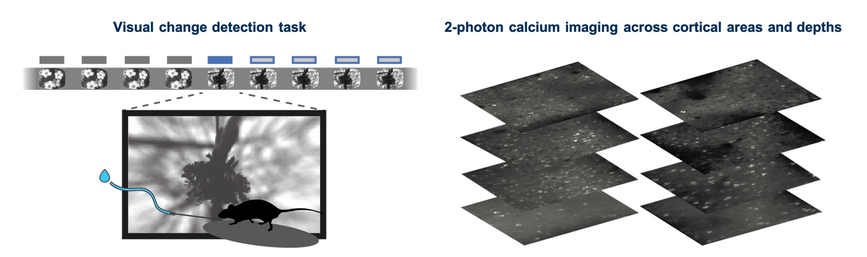

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

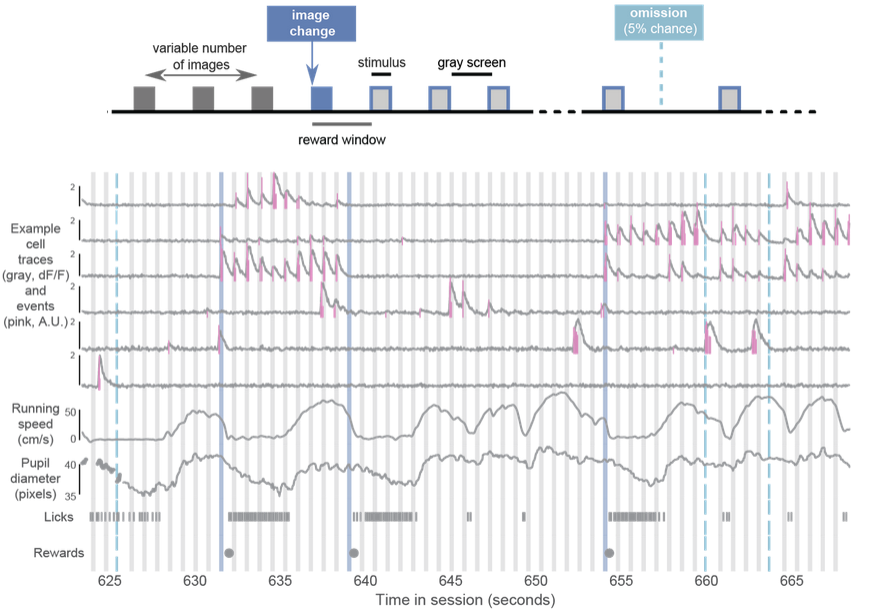

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [51]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [52]:
print(data["stim_table"])

      frame   start     end
0         0     737     744
1         1     745     752
2         2     752     759
3         3     760     767
4         4     767     774
...     ...     ...     ...
8875   8875  105705  105712
8876   8876  105712  105719
8877   8877  105720  105727
8878   8878  105727  105734
8879   8879  105735  105742

[8880 rows x 3 columns]


## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

In [53]:
data["stim_epoch_table"].columns = ["stimulus", "start", "end"]


locally_sparse_epochs = data["stim_epoch_table"][
    data["stim_epoch_table"]["stimulus"] == "locally_sparse_noise"
]

print(locally_sparse_epochs)
print(data["t"])

               stimulus  start     end
0  locally_sparse_noise    737   22461
3  locally_sparse_noise  41476   63199
6  locally_sparse_noise  82208  105742
[   9.33015    9.36332    9.39649 ... 3524.51876 3524.55193 3524.5851 ]


## Explore the data

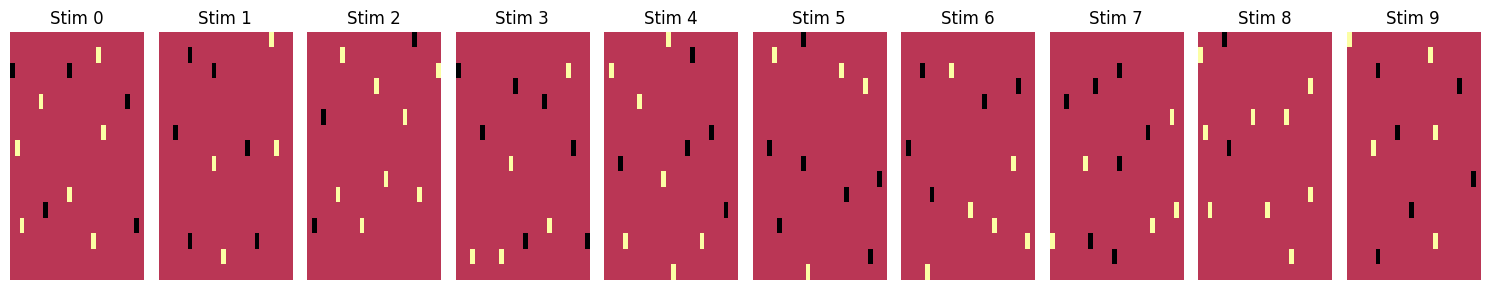

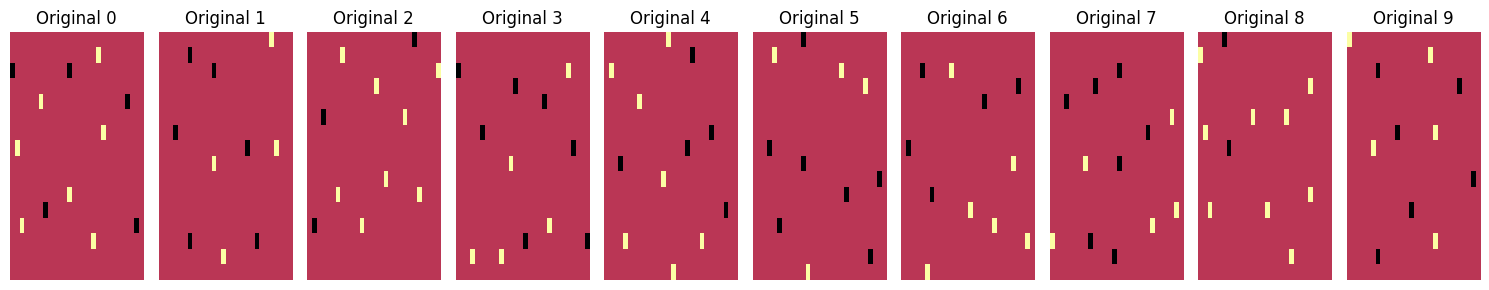

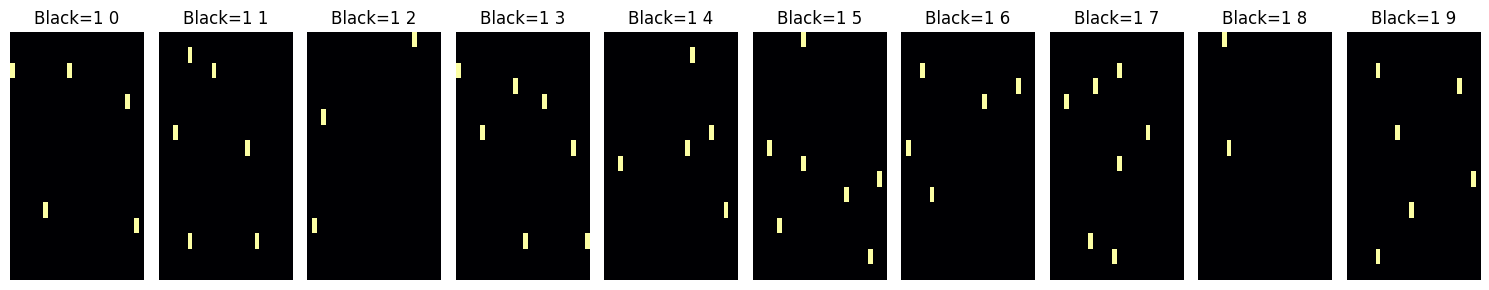

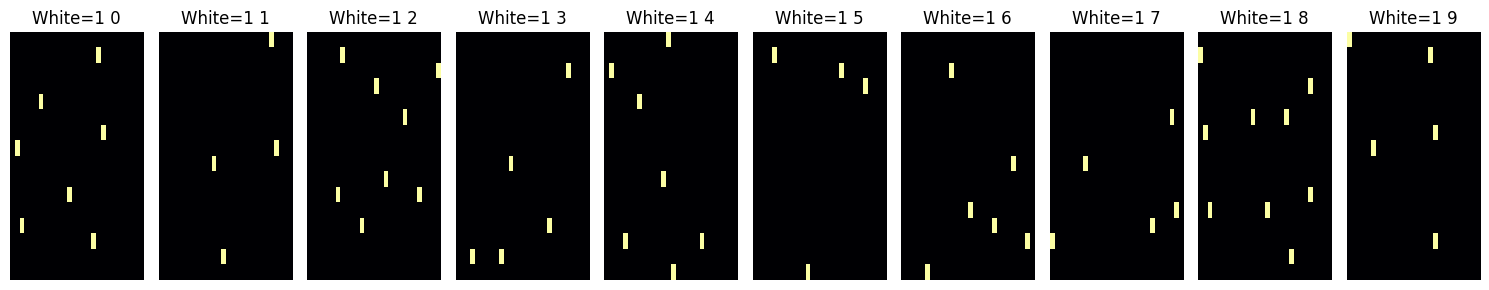

In [54]:
import matplotlib.pyplot as plt

# Extract the stim array
stim = data["stim"]  # shape: (9000, 16, 28)


# Plot the first 10 stimuli images
def plot_stimuli_images(stim, num_images=10):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(stim[i], cmap="inferno", aspect="auto")
        plt.axis("off")
        plt.title(f"Stim {i}")
    plt.tight_layout()
    plt.show()


plot_stimuli_images(stim)


# Extract the stim array
stim = data["stim"]  # shape: (9000, 16, 28)

# Binary: black → 1, rest → 0
stim_black_only = (stim == 0).astype(int)

# Binary: white → 1, rest → 0
stim_white_only = (stim == 255).astype(int)


# Plot the first 10 stimuli (original)
def plot_stimuli_images(stim, num_images=10, title_prefix="Stim"):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(stim[i], cmap="inferno", aspect="auto")
        plt.axis("off")
        plt.title(f"{title_prefix} {i}")
    plt.tight_layout()
    plt.show()


# Show all three for comparison
plot_stimuli_images(stim, title_prefix="Original")
plot_stimuli_images(stim_black_only, title_prefix="Black=1")
plot_stimuli_images(stim_white_only, title_prefix="White=1")
stim = stim_white_only

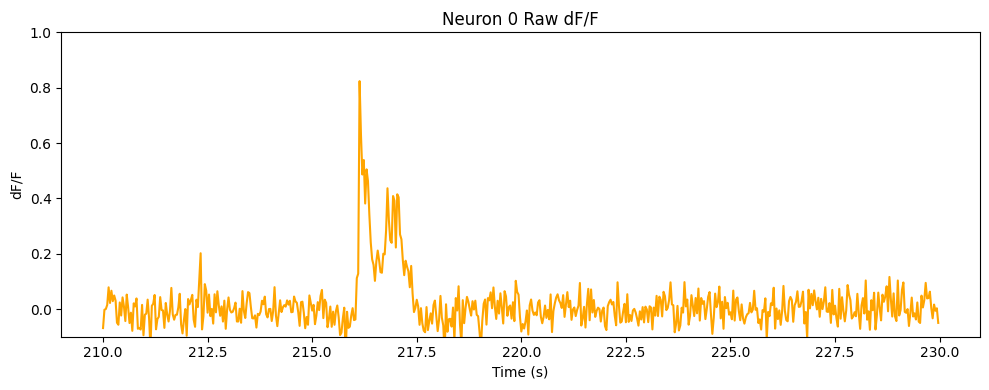

In [55]:
import matplotlib.pyplot as plt
import numpy as np


def plot_raw_trace(dff_raw, neuron_idx=0, fs=30.0, ylim=None, time_window=None):
    """
    Plot raw calcium trace for one neuron.

    Parameters:
    -----------
    dff_raw: np.ndarray, shape (neurons, time)
        Raw dF/F traces.

    neuron_idx: int
        Which neuron to plot (default 0).

    fs: float
        Sampling frequency in Hz.

    ylim: tuple or None
        y-axis limits as (min, max). If None, automatic scaling.

    time_window: tuple or None
        Time window to plot as (start_s, end_s). If None, plot entire trace.
    """
    n_timepoints = dff_raw.shape[1]
    total_time = n_timepoints / fs
    time = np.linspace(0, total_time, n_timepoints)

    if time_window is not None:
        start_idx = int(time_window[0] * fs)
        end_idx = int(time_window[1] * fs)
        time = time[start_idx:end_idx]
        trace = dff_raw[neuron_idx, start_idx:end_idx]
    else:
        trace = dff_raw[neuron_idx]

    plt.figure(figsize=(10, 4))
    plt.plot(time, trace, color="orange")
    plt.title(f"Neuron {neuron_idx} Raw dF/F")
    plt.xlabel("Time (s)")
    plt.ylabel("dF/F")
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


# Usage example:
plot_raw_trace(
    data["dff"], neuron_idx=0, fs=30.0, ylim=(-0.1, 1), time_window=(210, 230)
)

### Filter signal


/tmp/ipykernel_15390/2023625470.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y[channel] = y_channel_sos
/tmp/ipykernel_15390/2023625470.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y[channel] = y_channel_sos
/tmp/ipykernel_15390/2023625470.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

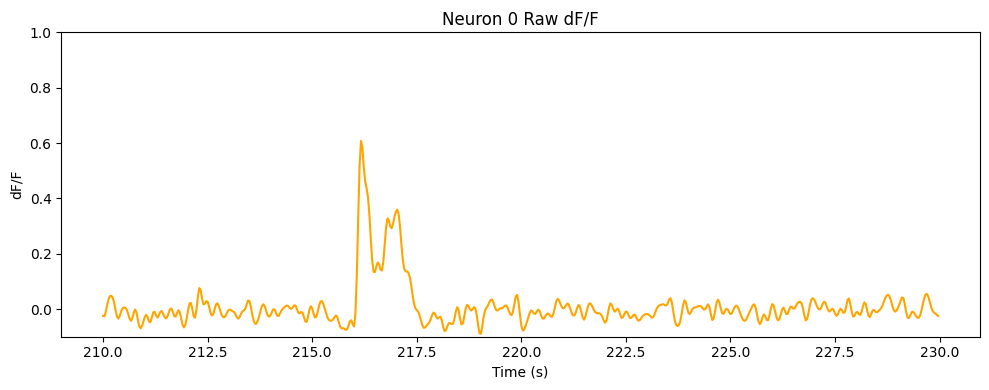

In [56]:
import scipy


# %matplotlib inline
## Current Best Practice
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """
    # -----------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1pt)
    # -----------------------------------------------------------------
    y = pd.DataFrame()
    assert 0 < low < high < fs / 2, "Invalid filter parameters"
    # Butterworth filter design
    # The filter is designed using the second-order sections (SOS) method.
    sos = scipy.signal.butter(
        N=order, Wn=[low, high], btype="band", output="sos", fs=fs
    )
    for channel in x.columns:
        y_channel_sos = scipy.signal.sosfiltfilt(sos, x[channel])
        y[channel] = y_channel_sos
    return y


# 1. Convert dff (neurons x time) -> DataFrame with shape (time, neurons)
dff = data["dff"]  # shape (189, 105968)
dff_df = pd.DataFrame(dff.T)  # transpose so rows=time, columns=neurons

# 2. Define your filter parameters
fs = 30.0  # example sampling frequency in Hz (change based on your data)
low_cutoff = 0.01  # low cutoff frequency in Hz (to remove slow drift)
high_cutoff = 5.0  # high cutoff frequency in Hz (to remove high freq noise)

# 3. Filter the dff signals
filtered_dff_df = filter_signal(
    dff_df, fs=fs, low=low_cutoff, high=high_cutoff, order=3
)

# 4. Convert back to numpy array with original shape (neurons x time)
filtered_dff = filtered_dff_df.T.values

# Replace in your data dict if you want
data["dff_filtered"] = filtered_dff

plot_raw_trace(
    data["dff_filtered"],
    neuron_idx=0,
    fs=30.0,
    ylim=(-0.1, 1),
    time_window=(210, 230),
)

# Deconvolution

In [57]:
#!pip install oasis
import oasis

In [58]:
print(filtered_dff.shape)
# Output: (189, 105968)

(189, 105968)


In [59]:
import oasis.functions
import numpy as np

# `filtered_dff` is shape (n_neurons, n_timepoints)
n_neurons, n_timepoints = filtered_dff.shape
spike_trains = np.zeros_like(filtered_dff)  # same shape to store results

for i in range(n_neurons):
    trace = filtered_dff[i]
    _, s, *_ = oasis.functions.deconvolve(trace, penalty=1.0, optimize_g=False)
    spike_trains[i] = s  # store deconvolved spikes

/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


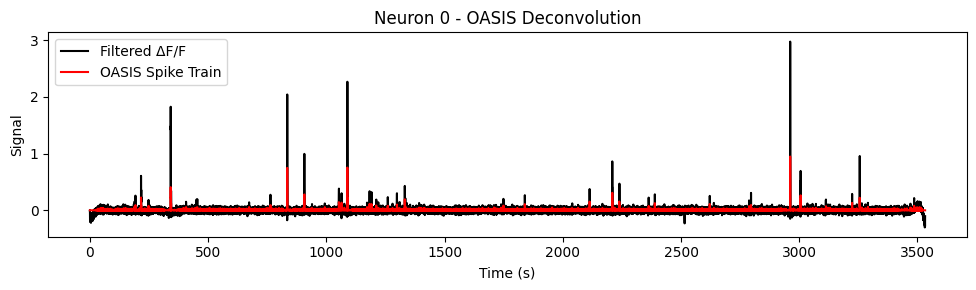

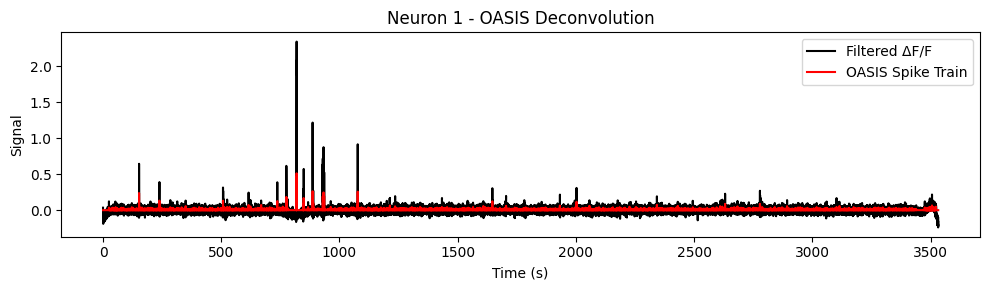

In [60]:
import matplotlib.pyplot as plt

num_neurons = filtered_dff.shape[0]
time = np.arange(filtered_dff.shape[1]) / fs  # fs = 30 Hz

for neuron_idx in range(2):
    plt.figure(figsize=(10, 3))
    plt.plot(time, filtered_dff[neuron_idx], label="Filtered ΔF/F", color="black")
    plt.plot(time, spike_trains[neuron_idx], label="OASIS Spike Train", color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.legend()
    plt.title(f"Neuron {neuron_idx} - OASIS Deconvolution")
    plt.tight_layout()
    plt.show()

In [61]:
"""
n_rois = spike_trains.shape[0]
n_lags = 6  # lag 0 = stimulus frame, lag 1 = next frame, etc.
stim_h, stim_w = stim.shape[1:]
receptive_fields = np.zeros((n_rois, n_lags, stim_h, stim_w))
spike_sums = np.zeros((n_rois, n_lags))

for _, row in data["stim_table"].iterrows():
    stim_idx = int(row["frame"])
    stim_img = stim[stim_idx]
    stim_start = int(row["start"])  # stimulus onset in frames

    for lag in range(n_lags):
        t = stim_start + lag
        if t >= spike_trains.shape[1]:
            continue

        spikes_at_lag = spike_trains[:,t]  # shape: (n_rois,)
        for roi in range(n_rois):
            receptive_fields[roi, lag] += spikes_at_lag[roi] * stim_img
            spike_sums[roi, lag] += spikes_at_lag[roi]
"""

'\nn_rois = spike_trains.shape[0]\nn_lags = 6  # lag 0 = stimulus frame, lag 1 = next frame, etc.\nstim_h, stim_w = stim.shape[1:]\nreceptive_fields = np.zeros((n_rois, n_lags, stim_h, stim_w))\nspike_sums = np.zeros((n_rois, n_lags))\n\nfor _, row in data["stim_table"].iterrows():\n    stim_idx = int(row["frame"])\n    stim_img = stim[stim_idx]\n    stim_start = int(row["start"])  # stimulus onset in frames\n\n    for lag in range(n_lags):\n        t = stim_start + lag\n        if t >= spike_trains.shape[1]:\n            continue\n\n        spikes_at_lag = spike_trains[:,t]  # shape: (n_rois,)\n        for roi in range(n_rois):\n            receptive_fields[roi, lag] += spikes_at_lag[roi] * stim_img\n            spike_sums[roi, lag] += spikes_at_lag[roi]\n'

In [62]:
"""
roi = 30  # choose neuron

for lag in range(n_lags):
    plt.imshow(receptive_fields[roi, lag], cmap="bwr")
    plt.title(f"ROI {roi} - Lag {lag}")
    plt.colorbar()
    plt.show()
"""

'\nroi = 30  # choose neuron\n\nfor lag in range(n_lags):\n    plt.imshow(receptive_fields[roi, lag], cmap="bwr")\n    plt.title(f"ROI {roi} - Lag {lag}")\n    plt.colorbar()\n    plt.show()\n'

In [63]:
n_frames, H, W = stim.shape
pixels = H * W
s = stim.reshape(n_frames, pixels).T  # shape: (pixels, n_frames)
# s = (s - s.mean(axis=1, keepdims=True)) / (s.std(axis=1, keepdims=True) + 1e-8)

print(s)
print(n_frames)
print(s.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
9000
(448, 9000)


In [64]:
# For neuron i:
neuron_idx = 0  # example
spikes = spike_trains[neuron_idx]  # shape (n_timepoints,)

# Bin spikes to stimulus frame indices
# If spike trains and stim frames are same length/time scale:
c = spikes.astype(int)  # integer spike counts per frame (rounded if needed)

In [65]:
import numpy as np

n_neurons = len(spike_trains)  # total neurons
n_timepoints = spike_trains[0].shape[
    0
]  # length of spike train (should be same for all neurons)

c_all = np.zeros((n_neurons, n_timepoints), dtype=int)

for i in range(n_neurons):
    spikes = spike_trains[i]
    # If spikes are floats representing firing rates, you might round or convert to ints
    c_all[i, :] = spikes.astype(int)  # just convert directly if already spike counts

# Now c_all shape: (n_neurons, n_timepoints)

In [66]:
n_neurons = spike_trains.shape[0]
n_stim_frames = stim.shape[0]
bin_size = (
    spike_trains.shape[1] // n_stim_frames
)  # how many spike samples per stim frame

c_all = np.zeros((n_neurons, n_stim_frames), dtype=int)

for neuron_idx in range(n_neurons):
    for i in range(n_stim_frames):
        start_idx = i * bin_size
        end_idx = (i + 1) * bin_size
        c_all[neuron_idx, i] = spike_trains[neuron_idx, start_idx:end_idx].sum()

In [67]:
from scipy.optimize import minimize
from utils import negloglike_lnp, deriv_negloglike_lnp
import numpy as np
from tqdm import tqdm
import os

dt = 0.1  # frame timestep
R = 50  # firing rate scaling factor

pixels = s.shape[0]  # e.g. 448 pixels
lags = [0, 1, 2, 3, 4]
n_lags = len(lags)
n_neurons = c_all.shape[0]  # number of neurons
w_hat = np.zeros((pixels, n_lags, n_neurons))  # store all fits


if os.path.exists("w_hat.npy"):
    w_hat = np.load("w_hat.npy")
else:
    for neuron_idx in tqdm(range(n_neurons), desc="Fitting neurons"):
        c = c_all[neuron_idx, :]  # spike counts for this neuron

        for i, lag in enumerate(lags):
            if lag > 0:
                S_lag = s[:, :-lag]
                c_lag = c[lag:]
            else:
                S_lag = s
                c_lag = c

            w0 = np.zeros(pixels)

            res = minimize(
                fun=lambda w: negloglike_lnp(w, c_lag, S_lag, dt=dt, R=R),
                x0=w0,
                jac=lambda w: deriv_negloglike_lnp(w, c_lag, S_lag, dt=dt, R=R),
                method="L-BFGS-B",
                options={"disp": False},
            )

            w_hat[:, i, neuron_idx] = res.x
    np.save("w_hat.npy", w_hat)
print(f"Finished fitting {n_neurons} neurons, weights shape: {w_hat.shape}")

Finished fitting 189 neurons, weights shape: (448, 5, 189)


In [68]:
print(c.shape)

(105968,)


In [69]:
"""
vmin = np.min(w_hat)
vmax = np.max(w_hat)

fig, axes = plt.subplots(n_neurons, n_lags, figsize=(2 * n_lags, 2 * n_neurons))

for neuron_idx in range(n_neurons):
    for i, lag in enumerate(lags):
        filter_img = w_hat[:, i, neuron_idx].reshape(H, W)

        ax = (
            axes[neuron_idx, i]
            if n_neurons > 1 and n_lags > 1
            else (axes[i] if n_neurons == 1 else axes[neuron_idx])
        )

        im = ax.imshow(filter_img, cmap="bwr", vmin=vmin, vmax=vmax)
        ax.axis("off")
        ax.set_title(f"N{neuron_idx}, L{lag}", fontsize=6)

plt.tight_layout()
plt.savefig("all_filters.png", dpi=300)
plt.show()
"""

'\nvmin = np.min(w_hat)\nvmax = np.max(w_hat)\n\nfig, axes = plt.subplots(n_neurons, n_lags, figsize=(2 * n_lags, 2 * n_neurons))\n\nfor neuron_idx in range(n_neurons):\n    for i, lag in enumerate(lags):\n        filter_img = w_hat[:, i, neuron_idx].reshape(H, W)\n\n        ax = (\n            axes[neuron_idx, i]\n            if n_neurons > 1 and n_lags > 1\n            else (axes[i] if n_neurons == 1 else axes[neuron_idx])\n        )\n\n        im = ax.imshow(filter_img, cmap="bwr", vmin=vmin, vmax=vmax)\n        ax.axis("off")\n        ax.set_title(f"N{neuron_idx}, L{lag}", fontsize=6)\n\nplt.tight_layout()\nplt.savefig("all_filters.png", dpi=300)\nplt.show()\n'

In [70]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n_neurons, n_lags, figsize=(3 * n_lags, 3 * n_neurons))
vmin = np.min(w_hat)
vmax = np.max(w_hat)

for neuron_idx in range(1):
    for i, lag in enumerate(lags):
        filter_img = w_hat[:, i, neuron_idx].reshape(H, W)

        if n_neurons == 1 and n_lags == 1:
            ax = axes
        elif n_neurons == 1:
            ax = axes[i]
        elif n_lags == 1:
            ax = axes[neuron_idx]
        else:
            ax = axes[neuron_idx, i]

        im = ax.imshow(
            filter_img, cmap="bwr", vmin=vmin, vmax=vmax
        )  # apply consistent range
        ax.set_title(f"Neuron {neuron_idx}, Lag {lag}")
        ax.axis("off")

# Add one colorbar for the whole figure
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, pad=0.02)
cbar.set_label("Filter Weight")

plt.tight_layout()
plt.savefig("filters_all_neurons_with_colorbar.png", dpi=100)
plt.show()
plt.close(fig)

/tmp/ipykernel_15390/1581540860.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [71]:
print(stim.shape)
c_all.shape[1]

(9000, 16, 28)


9000

In [ ]:
def bin_spikes_to_stim_frames(spike_trains, stim_table):
    """
    Bin spike trains based on stimulus timing from stim_table.

    Args:
        spike_trains: np.ndarray, shape (n_neurons, n_timepoints)
        stim_table: pd.DataFrame with columns ['frame', 'start', 'end']

    Returns:
        binned_spikes: np.ndarray, shape (n_neurons, n_stim_frames)
    """
    n_neurons, _ = spike_trains.shape
    n_stim_frames = stim_table.shape[0]

    binned_spikes = np.zeros((n_neurons, n_stim_frames))

    for i, row in stim_table.iterrows():
        start_idx = int(row["start"])
        end_idx = int(row["end"])
        binned_spikes[:, i] = spike_trains[:, start_idx:end_idx].sum(axis=1)

    return binned_spikes

In [78]:
# 1) Bin spikes by stim frames
binned_spikes = bin_spikes_to_stim_frames(
    spike_trains, data["stim_table"]
)  # (n_neurons, n_stim_frames)

# 2) Build lagged stimulus matrix from stim frames
n_lags = 10
X_lagged = build_lagged_stimulus(
    stim[:8880], n_lags
)  # (n_stim_frames - n_lags + 1, H*W*n_lags)

# 3) Align spikes by cutting off initial frames lost in lagging
spike_counts_lagged = binned_spikes[
    :, n_lags - 1 :
]  # (n_neurons, n_stim_frames - n_lags + 1)

In [81]:
def build_lagged_stimulus(stim, n_lags):
    """
    Build lagged design matrix for stimulus.

    stim: np.ndarray, shape (n_frames, H, W)
    n_lags: int, number of time lags to include

    Returns:
        X_lagged: np.ndarray, shape (n_frames - n_lags + 1, H * W * n_lags)
    """
    n_frames, H, W = stim.shape
    X_lagged = []

    for t in range(n_lags - 1, n_frames):
        lagged_frames = [stim[t - l].flatten() for l in range(n_lags)]
        X_lagged.append(np.concatenate(lagged_frames))

    return np.array(X_lagged)  # shape (n_frames - n_lags + 1, H * W * n_lags)


# Assuming spike_trains and stim_table are defined
spike_counts = bin_spikes_to_stim_frames(
    spike_trains, data["stim_table"]
)  # (n_neurons, n_stim_frames = 8880)

n_lags = 10  # change this to what you want
X_lagged = build_lagged_stimulus(
    stim[:8880], n_lags
)  # shape: (8880 - n_lags + 1, 448 * n_lags)

# Align spike counts (cut first n_lags - 1 entries)
spike_counts_lagged = spike_counts[
    :, n_lags - 1 :
]  # shape: (n_neurons, 8880 - n_lags + 1)

In [82]:
from sklearn.linear_model import Ridge

strfs = np.zeros((n_neurons, X_lagged.shape[1]))

for i in range(n_neurons):
    y = spike_counts_lagged[i]
    model = Ridge(alpha=0.1)
    model.fit(X_lagged, y)
    strfs[i] = model.coef_

KeyboardInterrupt: 

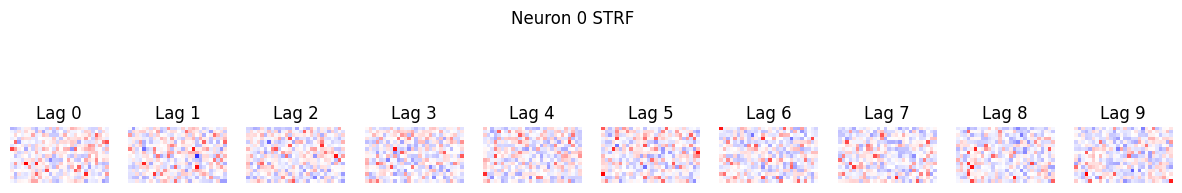

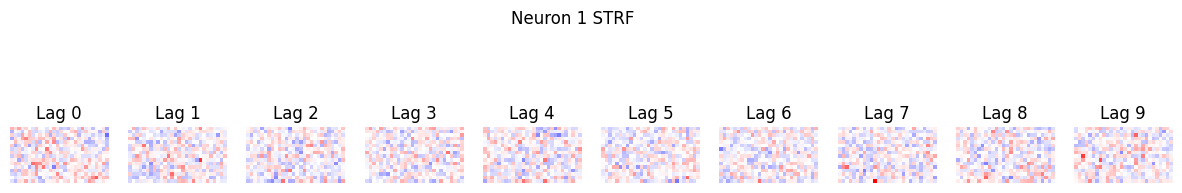

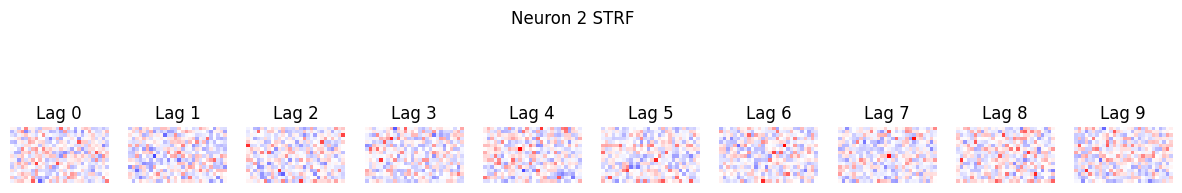

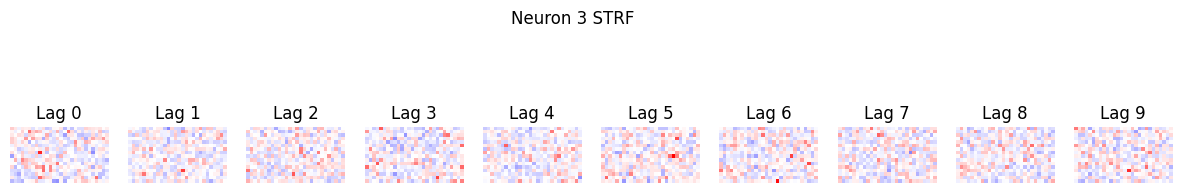

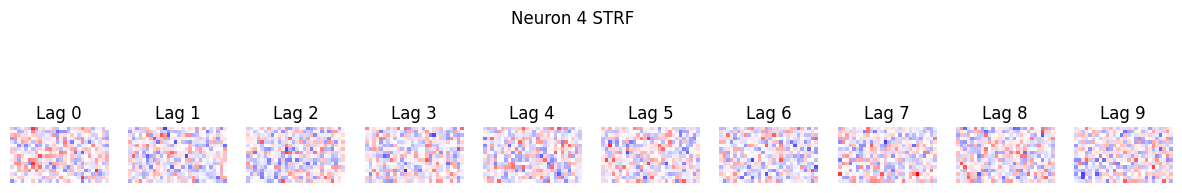

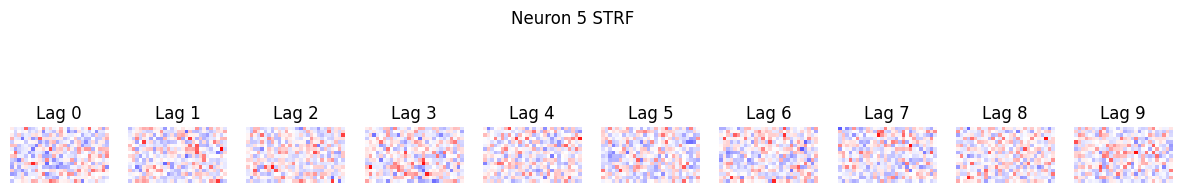

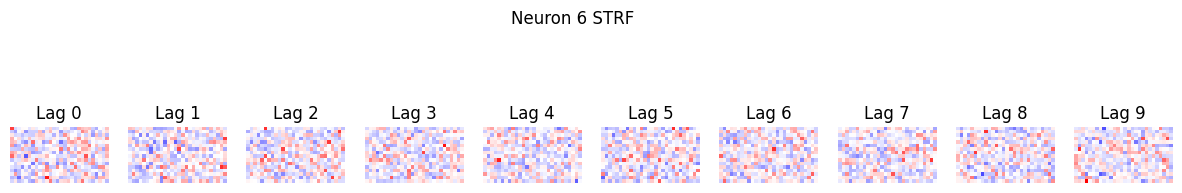

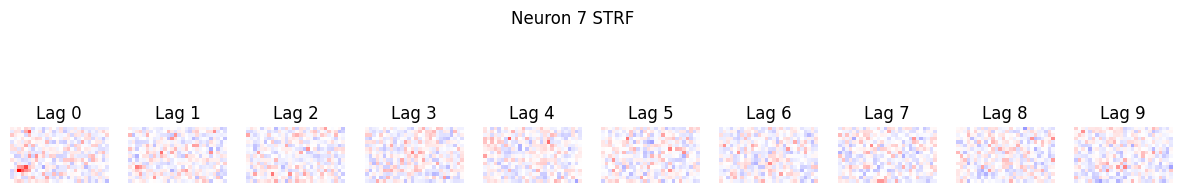

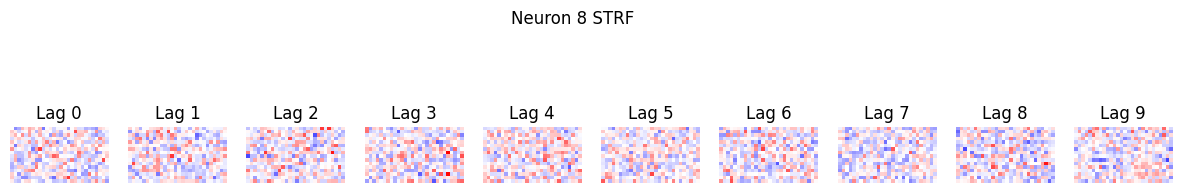

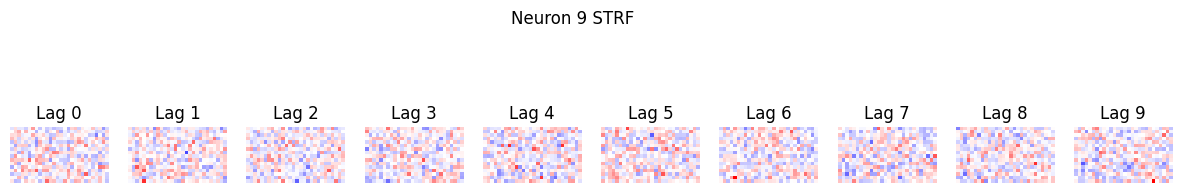

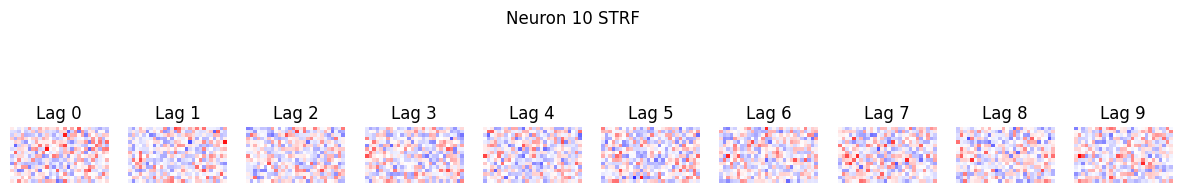

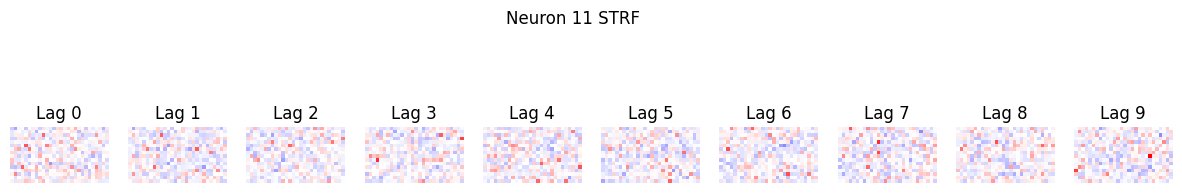

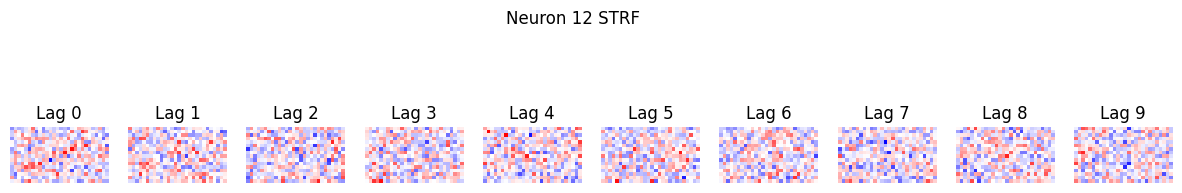

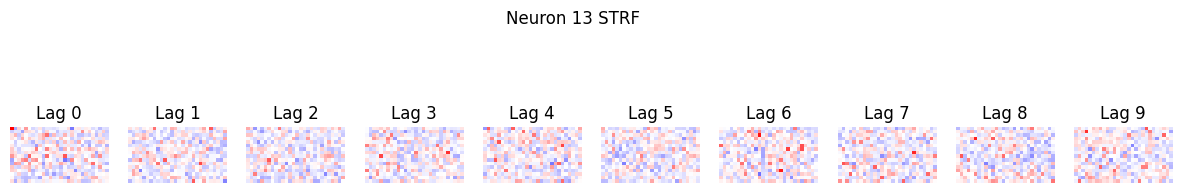

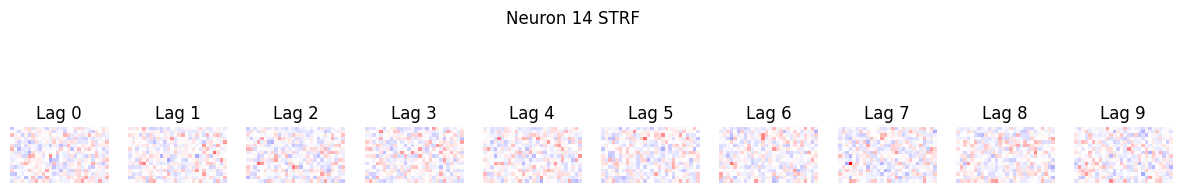

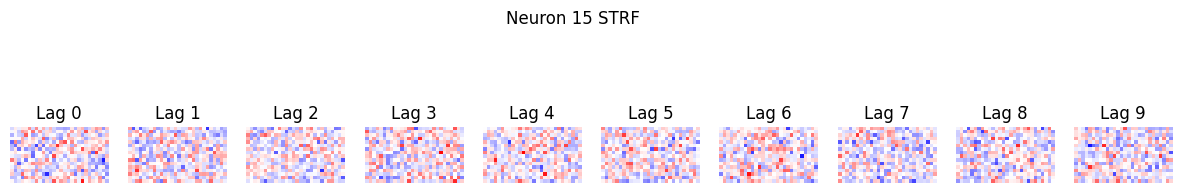

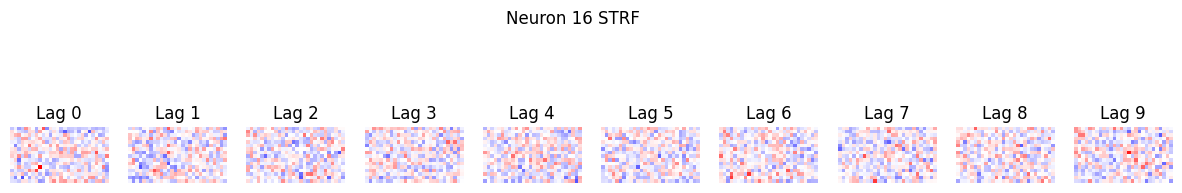

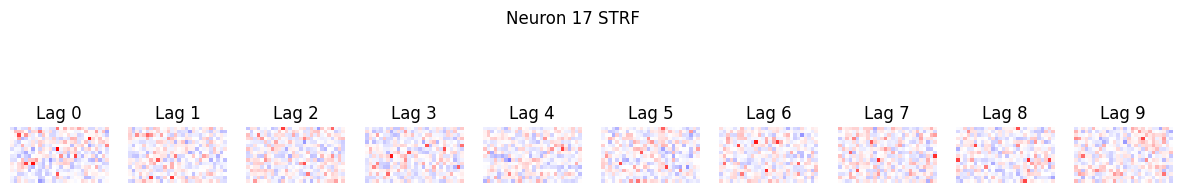

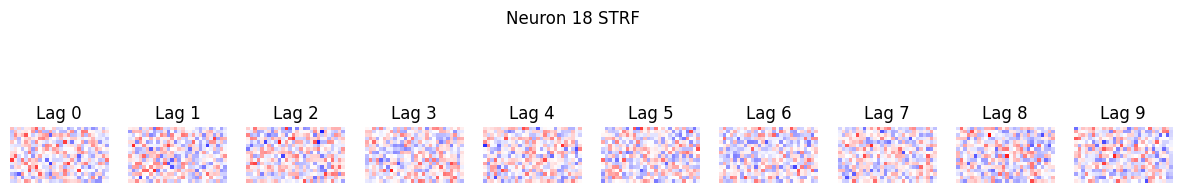

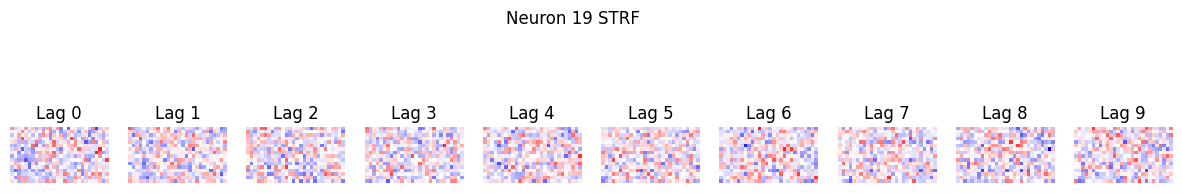

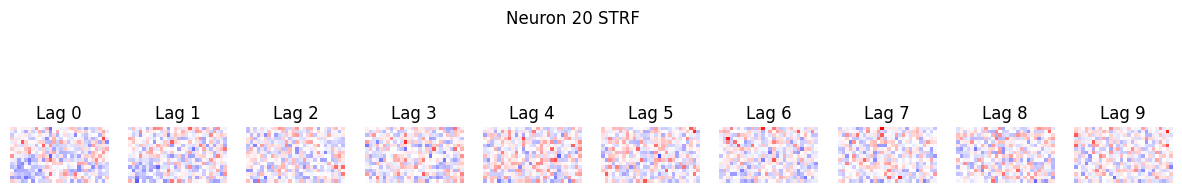

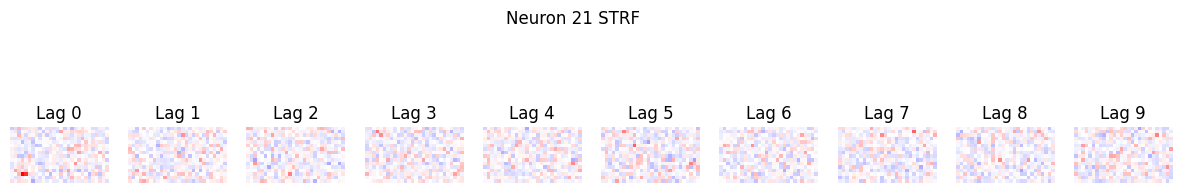

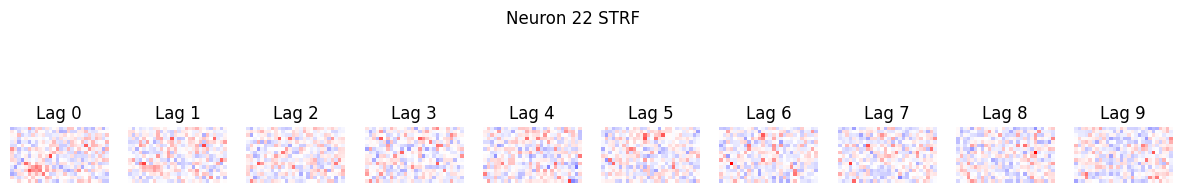

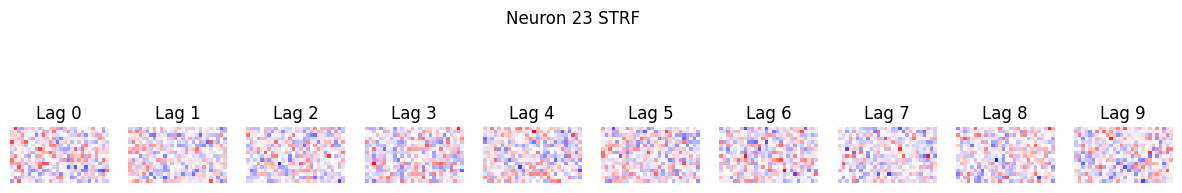

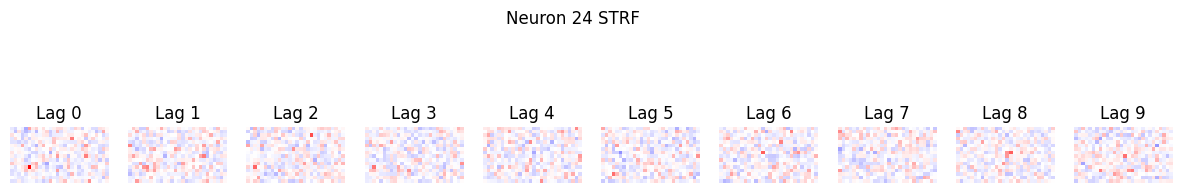

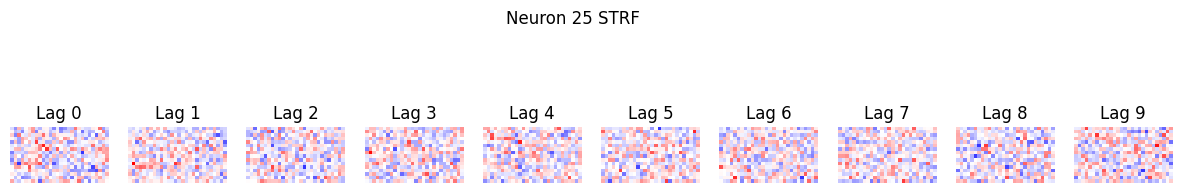

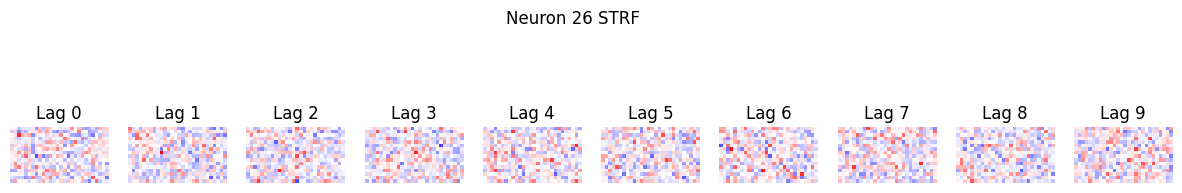

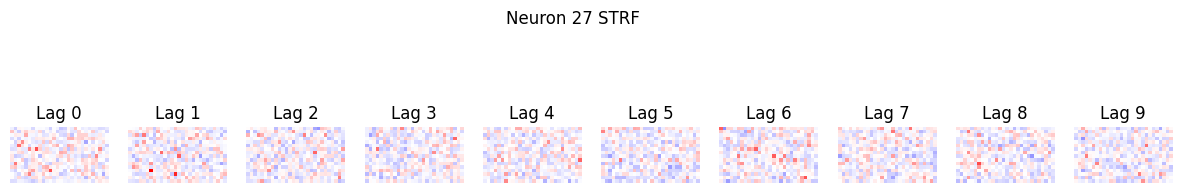

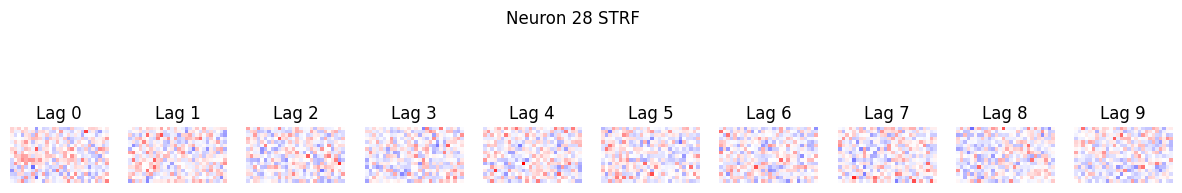

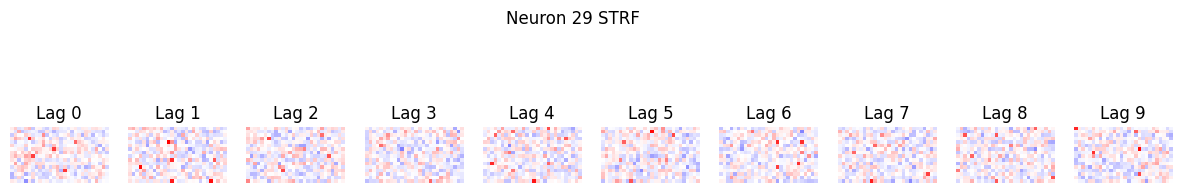

In [83]:
for i in range(30):  # first 3 neurons
    rf = strfs[i].reshape(n_lags, 16, 28)
    fig, axs = plt.subplots(1, n_lags, figsize=(15, 3))
    for j in range(n_lags):
        axs[j].imshow(
            rf[j], cmap="bwr", vmin=-np.max(np.abs(rf)), vmax=np.max(np.abs(rf))
        )
        axs[j].set_title(f"Lag {j}")
        axs[j].axis("off")
    plt.suptitle(f"Neuron {i} STRF")
    plt.show()

In [84]:
def raised_cosine_basis(n_lags, n_basis):
    import numpy as np
    from scipy.interpolate import interp1d

    # nonlinearly spaced centers
    t = np.linspace(0, np.log(n_lags + 1), n_basis)
    centers = np.exp(t) - 1
    width = (centers[1] - centers[0]) * 1.5

    basis = np.zeros((n_lags, n_basis))
    for i in range(n_basis):
        d = np.arange(n_lags) - centers[i]
        basis[:, i] = (np.cos(np.clip(d * np.pi / width, -np.pi, np.pi)) + 1) / 2
        basis[d > width / 2, i] = 0
        basis[d < -width / 2, i] = 0

    return basis  # shape: (n_lags, n_basis)

In [85]:
def build_temporal_basis_stimulus(stim, basis):  # stim: (T, H, W)
    T, H, W = stim.shape
    n_lags, n_basis = basis.shape
    out = np.zeros((T - n_lags + 1, H * W * n_basis))

    for b in range(n_basis):
        # Convolve stimulus with basis function across time
        for y in range(H):
            for x in range(W):
                stim_1d = stim[:, y, x]
                conv = np.convolve(stim_1d, basis[::-1, b], mode="valid")
                out[:, b * H * W + y * W + x] = conv
    return out  # (T - n_lags + 1, H * W * n_basis)

In [86]:
from sklearn.linear_model import RidgeCV
from tqdm import tqdm

basis = raised_cosine_basis(n_lags=10, n_basis=4)
X_basis = build_temporal_basis_stimulus(stim[:8880], basis)
Y = spike_counts[:, 10 - 1 :]  # align

models = []
for i in tqdm(range(32), desc="fitting"):
    model = RidgeCV(alphas=[0.1, 1.0, 10.0])
    model.fit(X_basis, Y[i])
    models.append(model)

fitting: 100%|██████████| 32/32 [08:26<00:00, 15.82s/it]


In [89]:
n_neurons = len(models)
n_lags = basis.shape[0]
n_basis = basis.shape[1]
H, W = 16, 28  # stim size

strfs = []

for model in models:
    # model.coef_: shape (n_basis * H * W,)
    spatial_rf = model.coef_.reshape(n_basis, H, W)
    # Combine temporal basis and spatial filters
    full_strf = np.tensordot(basis, spatial_rf, axes=[1, 0])  # shape: (n_lags, H, W)
    strfs.append(full_strf)

strfs = np.stack(strfs)  # shape: (n_neurons, n_lags, H, W)

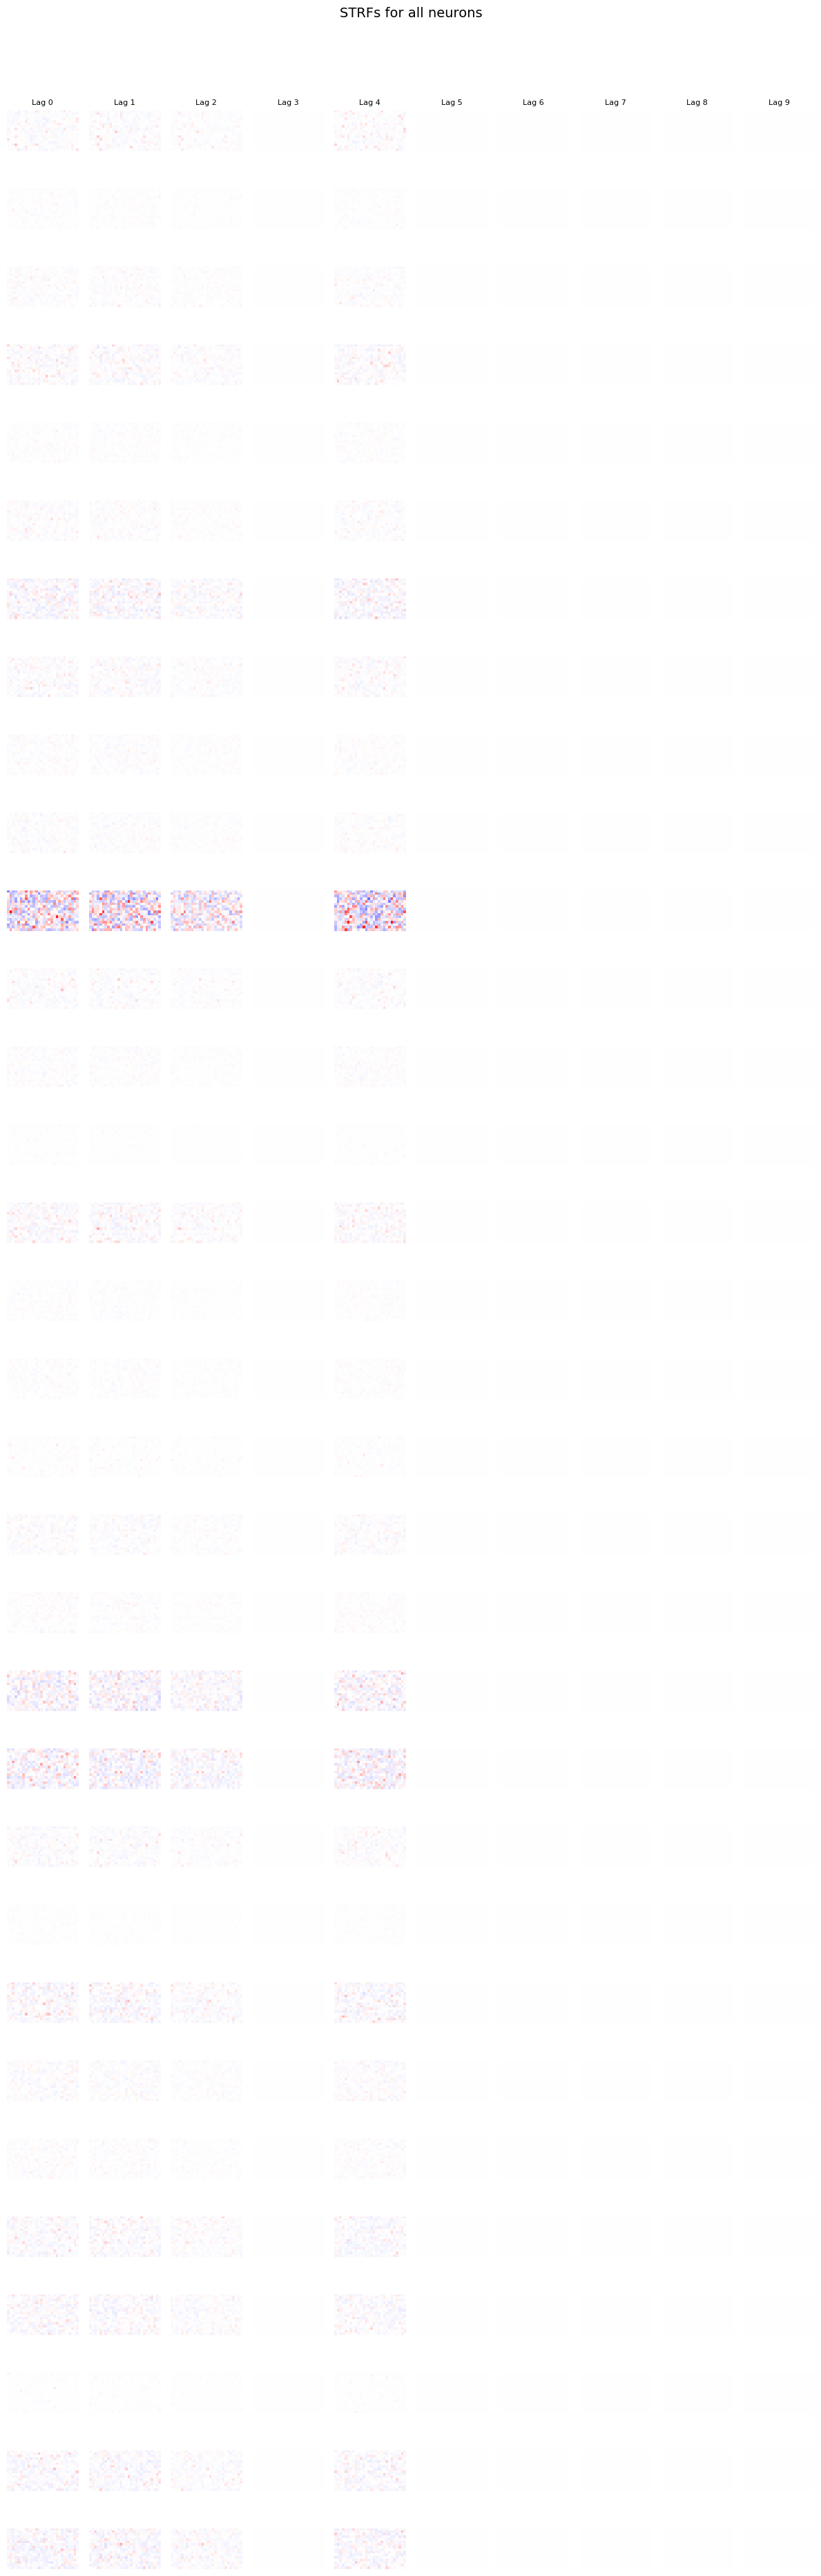

In [90]:
import matplotlib.pyplot as plt
import numpy as np

n_neurons, n_lags, H, W = strfs.shape

fig, axs = plt.subplots(n_neurons, n_lags, figsize=(n_lags * 1.2, n_neurons * 1.2))
vmax = np.max(np.abs(strfs))  # for symmetric color scale

for i in range(n_neurons):
    for lag in range(n_lags):
        ax = axs[i, lag] if n_neurons > 1 else axs[lag]
        ax.imshow(strfs[i, lag], cmap="bwr", vmin=-vmax, vmax=vmax)
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Lag {lag}", fontsize=8)
        if lag == 0:
            ax.set_ylabel(f"Neuron {i}", fontsize=8)

plt.suptitle("STRFs for all neurons", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from tqdm import tqdm

# Assumes: 
# - spike_counts: (n_neurons, T)
# - X_lagged: (T - n_lags + 1, n_features)
# - n_lags: number of lags in your model

glm_results_list = []
for i in tqdm(range(n_neurons), desc="Fitting Poisson GLMs"):
    y = spike_counts[i, n_lags - 1:]  # align response
    glm_model = sm.GLM(y, X_lagged, family=Poisson())
    glm_results = glm_model.fit()
    glm_results_list.append(glm_results)


Fitting Poisson GLMs:   3%|▎         | 1/32 [11:58<6:11:19, 718.69s/it]